# Pandas version of the code in "R for Marketing Research and Analytics"

## Ch 5 - Comparing Groups: Tables and Visualizations

### Jupyter template stuff

In [1]:
from IPython.core.interactiveshell import InteractiveShell

# pretty print only the last output of the cell
#InteractiveShell.ast_node_interactivity = "last_expr"
# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from IPython.display import Markdown, display
def printmd(string, color=None):
    if color:
        colorstr = "<span style='color:{}'>{}</span>".format(color, string)
        display(Markdown(colorstr))
    else:
        display(Markdown(string))

#printmd("## title text")
#printmd("**bold text**")
#printmd("**bold and blue**", color="blue")

In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import seaborn as sns
#import plotly.plotly as py
#import plotly
#plotly.offline.init_notebook_mode() # run at the start of every notebook
import scipy
import sklearn
from sklearn import preprocessing

# Danny, I think I will stop using statsmodels.api -- sklearn seems more mainstream
import statsmodels.api as sm # statistical modeling
import statsmodels.formula.api as smf

print(plt.style.available)
plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = 8, 4

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


### Simulating Consumer Segment Data

In [4]:
# specify the seed to make test results repeatable
np.random.seed(98250)

In [5]:
# Create list of dicts to hold all the info about the segments we'll create in the simulated data
variables = [
    {'name':'age', 'type':'norm',
     'mean':{'Suburb mix':40, 'Urban hip':24, 'Travelers':58, 'Moving up':36},
     'std_dev':{'Suburb mix':5, 'Urban hip':2, 'Travelers':8, 'Moving up':4}
    },
    {'name':'gender', 'type':'binom',
     'mean':{'Suburb mix':.5, 'Urban hip':0.7, 'Travelers':0.5, 'Moving up':0.3},
     'std_dev':{'Suburb mix':None, 'Urban hip':None, 'Travelers':None, 'Moving up':None}
    },
    {'name':'income', 'type':'norm',
     'mean':{'Suburb mix':55000, 'Urban hip':21000, 'Travelers':64000, 'Moving up':52000},
     'std_dev':{'Suburb mix':12000, 'Urban hip':5000, 'Travelers':21000, 'Moving up':10000}
    },
    {'name':'kids', 'type':'pois',
     'mean':{'Suburb mix':2, 'Urban hip':1, 'Travelers':0, 'Moving up':2},
     'std_dev':{'Suburb mix':None, 'Urban hip':None, 'Travelers':None, 'Moving up':None}
    },
    {'name':'ownHome', 'type':'binom',
     'mean':{'Suburb mix':0.5, 'Urban hip':0.2, 'Travelers':0.7, 'Moving up':0.3},
     'std_dev':{'Suburb mix':None, 'Urban hip':None, 'Travelers':None, 'Moving up':None}
    },
    {'name':'subscribe', 'type':'binom',
     'mean':{'Suburb mix':0.1, 'Urban hip':0.2, 'Travelers':0.05, 'Moving up':0.2},
     'std_dev':{'Suburb mix':None, 'Urban hip':None, 'Travelers':None, 'Moving up':None}
    }
]
segments = [
    {'name': 'Suburb mix', 'size':100},
    {'name': 'Urban hip', 'size':50},
    {'name': 'Travelers', 'size':80},
    {'name': 'Moving up', 'size':70},
]

In [6]:
test = pd.DataFrame([{'col1':[3,5,7,9,11], 'col2':[2,4,6,8,10]}])
test.iloc[:,0]

0    [3, 5, 7, 9, 11]
Name: col1, dtype: object

In [7]:
columns = []

for var in variables:
    # Start with empty dataframes each with one column
    # do this because we need to incrementally append info to each column
    # and we can't do this if these columns are already bound into a single
    # dataframe (dataframe columns must be equal length)
    # We will bind them into a single dataframe at the end
    thisVar = pd.DataFrame(columns=[var['name']]) # create a single-column DF
    
    for segment in segments:
        if var['type'] == 'norm':
            thisVar = pd.concat([thisVar, 
                                 pd.DataFrame(np.random.normal(loc=var['mean'][segment['name']], 
                                                               scale=var['std_dev'][segment['name']], 
                                                               size=segment['size']),
                                              columns=[var['name']])],
                                ignore_index=True)
        elif var['type'] == 'binom':
            thisVar = pd.concat([thisVar, 
                                 pd.DataFrame(np.random.binomial(n=1, p=var['mean'][segment['name']], size=segment['size']),
                                              columns=[var['name']])],
                                ignore_index=True)
        elif var['type'] == 'pois':
            thisVar = pd.concat([thisVar, 
                                          pd.DataFrame(np.random.poisson(lam=var['mean'][segment['name']], size=segment['size']),
                                                       columns=[var['name']])],
                                ignore_index=True)
        else:
            raise NotImplementedError()
    columns.append(thisVar)  # add a Dataframe to our list -- it is just a single-column DF

# Lastly, create the 'segment' column
segVar = pd.DataFrame(columns=['segment'])
for seg in segments:
    segVar = pd.concat([segVar, pd.DataFrame( [seg['name']] * seg['size'], columns=['segment'])], ignore_index=True)
columns.append(segVar)

# combine all the single-column DF into one DF
df_seg = pd.concat(columns, axis=1)
df_seg = df_seg.dropna()
# change the category variables into category type
df_seg.gender = df_seg.gender.astype('category')
df_seg.gender.cat.categories = ['m','f']
df_seg.ownHome = df_seg.ownHome.astype('category')
df_seg.ownHome.cat.categories = ['n','y']
df_seg.subscribe = df_seg.subscribe.astype('category')
df_seg.subscribe.cat.categories = ['n','y']
df_seg.segment = df_seg.segment.astype('category')

df_seg.info()
df_seg

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        300 non-null    float64 
 1   gender     300 non-null    category
 2   income     300 non-null    float64 
 3   kids       300 non-null    object  
 4   ownHome    300 non-null    category
 5   subscribe  300 non-null    category
 6   segment    300 non-null    category
dtypes: category(4), float64(2), object(1)
memory usage: 11.0+ KB


,age,gender,income,kids,ownHome,subscribe,segment
0,41.724072,f,53233.127099,1,y,n,Suburb mix
1,40.119614,f,52590.849199,2,n,n,Suburb mix
2,34.550190,m,49683.657583,4,n,n,Suburb mix
3,40.266336,f,47678.052734,0,y,n,Suburb mix
4,37.788147,f,63559.376031,5,n,n,Suburb mix
...,...,...,...,...,...,...,...
295,32.785987,m,49997.775565,0,n,n,Moving up
296,41.512920,f,53096.927940,1,n,y,Moving up
297,35.442661,f,42615.556251,3,y,y,Moving up
298,40.854076,m,57632.863058,2,n,y,Moving up


In [8]:
'''OLD'''

'''
DFs = {var['name']:pd.DataFrame(columns=[var['name']]) for var in variables} 
DFs['segment'] = pd.DataFrame(columns=['segment'])

for i, segment in enumerate(segments):
    DFs['segment'] = pd.concat([DFs['segment'], pd.DataFrame([segment['name'],] * segment['size'], columns=['segment'])],
              ignore_index=True) #pd.concat takes a list of DataFrames as it's first argument (or Series).  Here I create a list of 2 DFs
    
    for j, var in enumerate(variables):
        if var['type'] == 'norm':
            DFs[var['name']] = pd.concat([DFs[var['name']], 
                                          pd.DataFrame(np.random.normal(loc=var['mean'][segment['name']], 
                                                                        scale=var['std_dev'][segment['name']],
                                                                        size=segment['size']),
                                                       columns=[var['name']])],
                                         ignore_index=True)
        elif var['type'] == 'binom':
            DFs[var['name']] = pd.concat([DFs[var['name']], 
                                          pd.DataFrame(np.random.binomial(n=1, p=var['mean'][segment['name']], size=segment['size']),
                                                       columns=[var['name']])],
                                         ignore_index=True)
        elif var['type'] == 'pois':
            DFs[var['name']] = pd.concat([DFs[var['name']], 
                                          pd.DataFrame(np.random.poisson(lam=var['mean'][segment['name']], size=segment['size']),
                                                       columns=[var['name']])],
                                         ignore_index=True)
        else:
            raise NotImplementedError()
            
# combine all the single-column DF into one DF
df_seg = pd.concat(list(DFs.values()), axis=1)
df_seg = df_seg.dropna()
# change the category variables into category type
df_seg.gender = df_seg.gender.astype('category')
df_seg.gender.cat.categories = ['m','f']
df_seg.ownHome = df_seg.ownHome.astype('category')
df_seg.ownHome.cat.categories = ['n','y']
df_seg.subscribe = df_seg.subscribe.astype('category')
df_seg.subscribe.cat.categories = ['n','y']
df_seg.segment = df_seg.segment.astype('category')

df_seg.info()
df_seg
'''

'OLD'

"\nDFs = {var['name']:pd.DataFrame(columns=[var['name']]) for var in variables} \nDFs['segment'] = pd.DataFrame(columns=['segment'])\n\nfor i, segment in enumerate(segments):\n    DFs['segment'] = pd.concat([DFs['segment'], pd.DataFrame([segment['name'],] * segment['size'], columns=['segment'])],\n              ignore_index=True) #pd.concat takes a list of DataFrames as it's first argument (or Series).  Here I create a list of 2 DFs\n    \n    for j, var in enumerate(variables):\n        if var['type'] == 'norm':\n            DFs[var['name']] = pd.concat([DFs[var['name']], \n                                          pd.DataFrame(np.random.normal(loc=var['mean'][segment['name']], \n                                                                        scale=var['std_dev'][segment['name']],\n                                                                        size=segment['size']),\n                                                       columns=[var['name']])],\n                     

### Finding Descriptives by Group

In [9]:
# One-off descriptives:
df_seg.loc[(df_seg.segment == 'Moving up') & (df_seg.subscribe == 'n'),['income']].mean()

income    52756.120458
dtype: float64

In [10]:
# That is tedious for many comparisons.  Use groupby for more automation
df_seg.groupby(['segment', 'subscribe','gender', 'ownHome']).mean()

age        income
segment    subscribe gender ownHome                         
Moving up  n         m      n        36.719210  52701.500042
                            y        35.741260  53805.563170
                     f      n        36.834675  52885.039102
                            y        36.611870  51798.421450
           y         m      n        35.048562  55354.826657
                            y        33.080877  54020.551315
                     f      n        36.866831  50937.154819
                            y        37.067649  53734.108918
Suburb mix n         m      n        38.770829  54178.950181
                            y        40.723399  58146.668100
                     f      n        38.629463  53203.332584
                            y        41.445079  55323.941619
           y         m      n        40.194291  70423.204445
                            y        42.137738  52267.557570
                     f      n        42.691823  55705.886961
                            y        41.162742  58228.114190
Travelers  n         m      n        59.390698  53459.312489
                            y        58.261859  64646.951360
                     f      n        59.784178  76058.981898
                            y        58.563014  63964.327431
           y         m      n              NaN           NaN
                            y              NaN           NaN
                     f      n        68.284094  65738.546154
                            y              NaN           NaN
Urban hip  n         m      n        24.265180  19670.667577
                            y        24.571326  19920.098843
                     f      n        24.012280  22957.405741
                            y        24.354675  18921.466427
           y         m      n        24.410017  23797.594971
                            y        23.169777  22965.141709
                     f      n        24.380086  20905.153073
                            y        22.267581  19597.794659

In [11]:
# Say we wanted to add a column of the segment mean income for each row?
# First, save the segment mean incomes
segMeanIncomes = df_seg.groupby(['segment']).mean().loc[:,['income']]
segMeanIncomes
# Second, look up the right mean income for each row by using
# our dataframe's segment column as the row indexer into segMeanIncomes.
# NOTE: this is interesting because segMeansIncomes has only 4 rows
#       and yet we are indexing into it with 300 values, but since all of those
#       300 values match one of the 4 row indices, it works.  The output
#       is 300 values each (just write for assigning to a new column of our DF)
segMeanIncomes.loc[df_seg.segment,['income']]
df_seg['segIncome'] = segMeanIncomes.loc[df_seg.segment,['income']].values
df_seg.sample(5)

# normally we don't like adding derived data to the table, so we'll delete this
# new column now
df_seg = df_seg.drop(columns='segIncome')
df_seg.sample(5)

,income
segment,
Moving up,52837.763183
Suburb mix,55624.728819
Travelers,63265.741717
Urban hip,21254.279724


,income
segment,
Suburb mix,55624.728819
Suburb mix,55624.728819
Suburb mix,55624.728819
Suburb mix,55624.728819
Suburb mix,55624.728819
...,...
Moving up,52837.763183
Moving up,52837.763183
Moving up,52837.763183


,age,gender,income,kids,ownHome,subscribe,segment,segIncome
184,56.312132,f,38157.296670,0,y,n,Travelers,63265.741717
52,43.259464,f,45812.888365,0,y,y,Suburb mix,55624.728819
100,26.610553,f,21212.281991,0,n,y,Urban hip,21254.279724
225,53.641260,f,18628.780592,0,y,n,Travelers,63265.741717
189,59.370301,m,100635.042835,0,y,n,Travelers,63265.741717


,age,gender,income,kids,ownHome,subscribe,segment
75,49.699595,f,62021.824072,4,y,n,Suburb mix
275,33.581018,m,66787.164719,1,n,n,Moving up
293,35.551002,m,58293.724398,3,n,n,Moving up
33,41.628773,f,42861.604396,1,n,n,Suburb mix
166,64.469025,m,61670.140406,0,n,n,Travelers


### Descriptions for Two-Way Groups

In [12]:
# this first form will just give us counts
pd.crosstab(index=df_seg.segment, columns=df_seg.ownHome)

# with the values and aggfunc arguments, it can summarize a third variable
pd.crosstab(index=df_seg.segment, columns=df_seg.ownHome, values=df_seg.income, aggfunc=np.mean)

ownHome,n,y
segment,,
Moving up,50,20
Suburb mix,43,57
Travelers,19,61
Urban hip,39,11


ownHome,n,y
segment,,
Moving up,52717.302147,53138.915772
Suburb mix,54186.789601,56709.489984
Travelers,60052.869369,64266.472449
Urban hip,21610.725114,19990.518795


In [13]:
# The below crosstab treats kids as a categorical
pd.crosstab(df_seg.kids, df_seg.segment)

# but kids is also a count variable.  Here is a summary
# of the total number of kids in each segment (among the respondants)
pd.pivot_table(data=df_seg, index='segment', values='kids', aggfunc=np.sum)


segment,Moving up,Suburb mix,Travelers,Urban hip
kids,,,,
0,12,13,80,26
1,18,24,0,14
2,18,30,0,8
3,12,20,0,2
4,8,7,0,0
5,2,4,0,0
6,0,2,0,0


,kids
segment,
Moving up,132
Suburb mix,204
Travelers,0
Urban hip,36


### Visualization by Group: Frequencies and Proportions

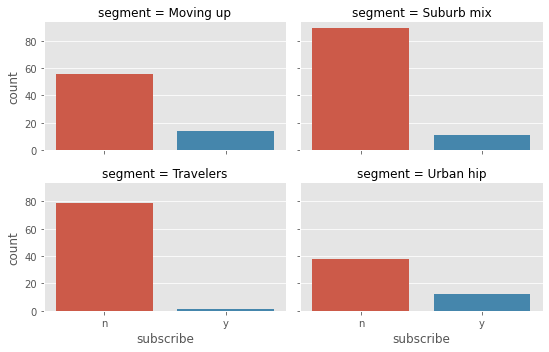

In [14]:
g = sns.catplot("subscribe", col="segment", col_wrap=2,
                data=df_seg,
                kind="count", height=2.5, aspect=1.5)

subscribe,n,y
segment,,
Moving up,0.8000,0.2000
Suburb mix,0.8900,0.1100
Travelers,0.9875,0.0125
Urban hip,0.7600,0.2400


subscribe,segment,n,y
0,Moving up,0.8000,0.2000
1,Suburb mix,0.8900,0.1100
2,Travelers,0.9875,0.0125
3,Urban hip,0.7600,0.2400


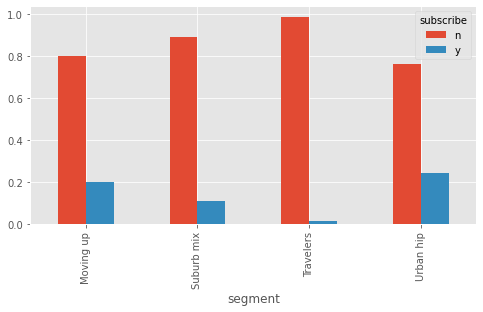

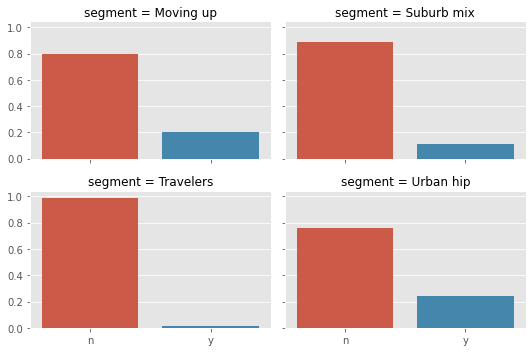

In [15]:
# for the same plot, but showing "percent of total" rather than count,
# feed it the data from a crosstab that has the 'normalize' option 
# specified.
percent_data = pd.crosstab(index=df_seg.segment.astype('object'), columns=df_seg.subscribe.astype('object'), normalize='index')
percent_data
# a simple DataFrame.plot.bar() works here
percent_data.plot.bar()

# But if you want to use seaborn catplot, you need to massage the data
# This crosstab has one of the variables (segment) in the index and one
# of the variables (subscribe) has it's values split up as columns 'y' and 'n'.
# To fix the segment index and pull it into a column, we use .reset_index()
percent_data = percent_data.reset_index()
percent_data
# Now we can graph it with seaborn if we use kind='bar' and do not
# specify an x or y (because seaborn barplot expects wide-form data
# if no x or y are given, otherwise, it expects the normal long-form)
g = sns.catplot( col="segment", col_wrap=2,
                data=percent_data,
                kind="bar", height=2.5, aspect=1.5)



In [16]:
# By the way, if we had needed to fix the (subscribe) and
# bring its 'y' and 'n' columns back into
# on column called subscribe, we would need to use melt()
percent_data.melt(id_vars=['segment'], 
                                 value_vars=['n','y'], 
                                 var_name='subscribe')


,segment,subscribe,value
0,Moving up,n,0.8000
1,Suburb mix,n,0.8900
2,Travelers,n,0.9875
3,Urban hip,n,0.7600
4,Moving up,y,0.2000
5,Suburb mix,y,0.1100
6,Travelers,y,0.0125
7,Urban hip,y,0.2400


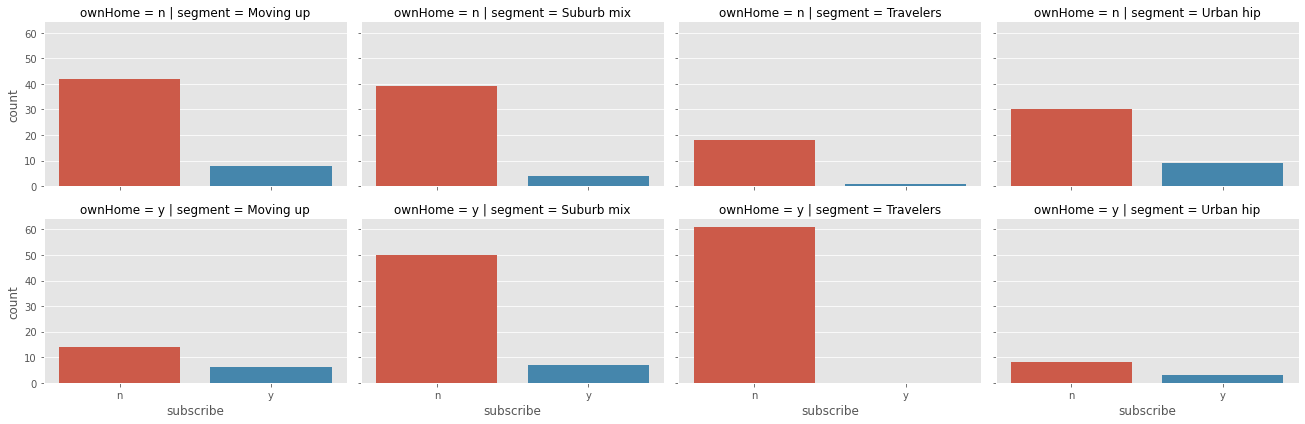

In [17]:
# Doing two categories at once (segment and ownHome)
g = sns.catplot("subscribe", col="segment", row='ownHome',
                data=df_seg,
                kind="count", height=3, aspect=1.5)

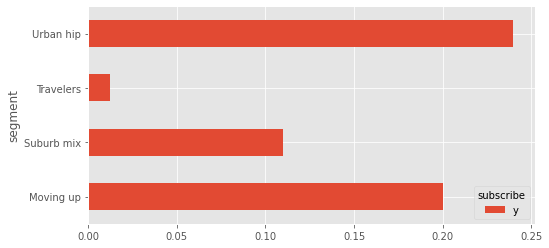

In [18]:
# If we just wanted to plot the yes bars:
percent_data = pd.crosstab(index=df_seg.segment.astype('object'), columns=df_seg.subscribe.astype('object'), normalize='index')
percent_data.loc[:,['y']].plot.barh()

### Visualization by Group: Continuous Data

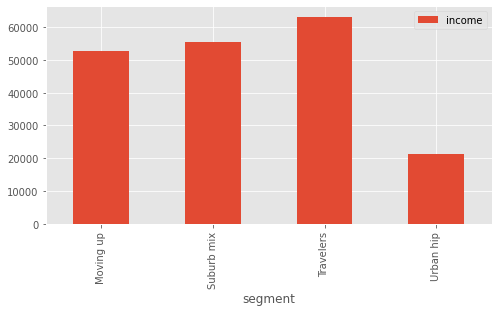

In [19]:
# Let's summarize average income by segment
df_seg.groupby(['segment']).mean().loc[:,['income']].plot.bar()

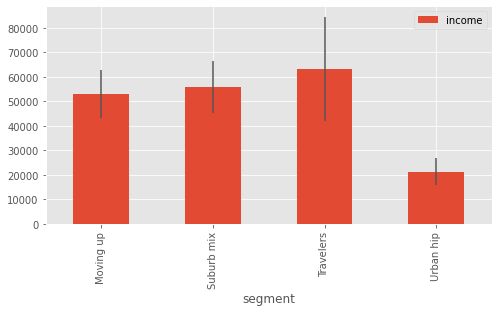

In [20]:
# Add error bars
gb = df_seg.loc[:,['segment','income']].groupby(['segment'])
means = gb.mean()
errors = gb.std()
means.plot.bar(yerr=errors)


age        income
segment    ownHome                         
Moving up  n        36.654517  52717.302147
           y        35.646536  53138.915772
Suburb mix n        39.008451  54186.789601
           y        41.128090  56709.489984
Travelers  n        59.962319  60052.869369
           y        58.429716  64266.472449
Urban hip  n        24.183761  21610.725114
           y        24.008590  19990.518795

age                   income              
ownHome             n          y             n             y
segment                                                     
Moving up   36.654517  35.646536  52717.302147  53138.915772
Suburb mix  39.008451  41.128090  54186.789601  56709.489984
Travelers   59.962319  58.429716  60052.869369  64266.472449
Urban hip   24.183761  24.008590  21610.725114  19990.518795

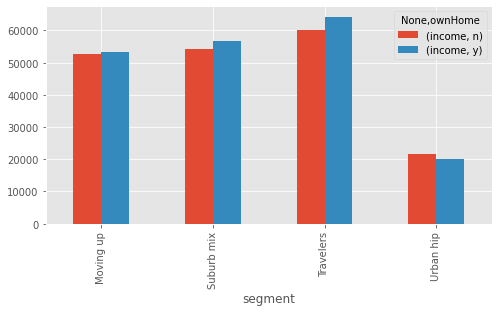

In [21]:
# Now also break out home ownership
t = df_seg.groupby(['segment','ownHome']).mean()
t
t=t.unstack()
t
t.loc[:,['income']].plot.bar()

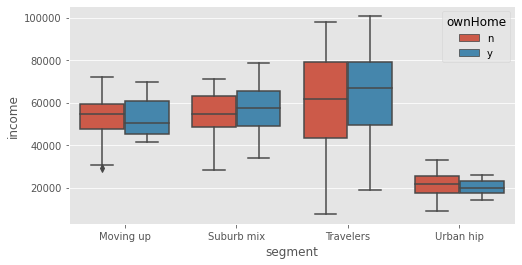

In [22]:
# A boxplot is better for showing the range as well as mean of these continuous variables.
ax = sns.boxplot(x="segment", y="income", hue='ownHome', data=df_seg)


### Save this data for the next chapter

In [23]:
with open('ch5_data_cust_seg.json', 'w') as f:
    df_seg.to_json(f, date_format='iso', orient='records')
